## Transfer Learning

In practice, we do not train deep learning from scratch i.e. with random initialization. Instead, we use pretrained weights and finetune on our dataset.

In this tutorial, we'll load the pretrained alexnet model and finetune on our dataset to classify between ants and bees.

### Reference:
1. http://cs231n.github.io/transfer-learning/
2. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os



import copy

plt.ion()   # interactive mode


- The problem we’re going to solve today is to train a model to classify **ants** and **bees**. 
- We have about **120 training images** each for ants and bees. 
- There are **75 validation images** for each class. 
- Usually, this is a very small dataset to generalize upon, if trained from scratch. 
- Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)

Using PyTorch version: 0.3.0.post4 CUDA: True


#### Visualize few Images

Let’s visualize a few training images so as to understand the data augmentations.

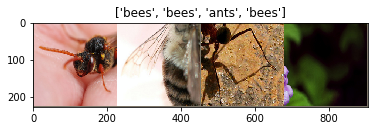

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


Now, let’s write a general function to train a model. Here, we will illustrate:

-    Saving the best model



- Load a pretrained model 
- Freeze the layer
- Reset the final fully connected layer and we'll only train this layer



In [4]:
def train(epoch, log_interval=1000):
    model.train()
    for batch_idx, (data, target) in enumerate(dataloaders['train']):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloaders['train'].dataset),
                100. * batch_idx / len(dataloaders['train']), loss.data[0]))

In [5]:

def test(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for batch_idx, (data, target) in enumerate(dataloaders['val']):
        
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        val_loss += loss_func(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(dataloaders['val'])
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(dataloaders['val'].dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        val_loss, correct, len(dataloaders['val'].dataset), accuracy))

- Pop the last fully connected layer
- Add a new fully connected layer
- Fine-tune the model

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
if cuda:
    model = model.cuda()

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



### Train the model

In [ ]:
%%time
epochs = 5

lossv, accv = [], [] # used to keep track of train progress (used in the next cell)
for epoch in range(1, epochs + 1):
    train(epoch)
    test(lossv, accv)


Train Epoch: 1 [0/244 (0%)]	Loss: 1.030659

Validation set: Average loss: 0.5665, Accuracy: 119/153 (77.7778%)

Train Epoch: 2 [0/244 (0%)]	Loss: 0.076610

Validation set: Average loss: 0.5119, Accuracy: 126/153 (82.3529%)

Train Epoch: 3 [0/244 (0%)]	Loss: 1.733763

Validation set: Average loss: 0.2360, Accuracy: 138/153 (90.1961%)

Train Epoch: 4 [0/244 (0%)]	Loss: 1.208658
